In this notebook, we will build an agent that acts as a restaurant waiter, capable of interacting with customers, answering their questions about the menu, and providing friendly responses. We will use the LangChain and LangGraph libraries to construct the agent's workflow and integrate it with OpenAI's GPT-based language models.

# Libraries, API Keys and Data

We need to install several libraries to build our agent:
*   langchain-community and langchain-openai: For language model integrations and prompts.
*   unstructured: For document loading and processing.
*   faiss-cpu: For vector similarity search.
*   langgraph: For constructing the workflow graph.

In [ ]:
!pip install -q langchain-community langchain-openai unstructured faiss-cpu langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 778.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
%cd /content/drive/MyDrive/GenAI/RAG/Agentic RAG

/content/drive/MyDrive/GenAI/RAG/Agentic RAG


We import necessary modules from LangChain and LangGraph. Make sure your OpenAI API key is stored with the key 'genai_course' in Colab's user data.

In [ ]:
from google.colab import userdata
api_key = userdata.get('genai_course')

In [ ]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import display, Image

from langgraph.graph import StateGraph, END

We use UnstructuredExcelLoader to load data from the Excel file containing the restaurant menu. The mode="elements" parameter ensures the data is loaded as individual elements.

In [ ]:
# Specify the path to the Excel file containing the menu
file = 'dim sum montijo.xlsx'

# Create an instance of the loader with the specified mode
loader = UnstructuredExcelLoader(file, mode="elements")

# Load the data from the Excel file
data = loader.load()

We create embeddings for the menu data using OpenAIEmbeddings. FAISS is used to create a vector store from the documents, enabling efficient similarity search.



In [ ]:
# Initialize the embeddings model with the OpenAI API key
embeddings = OpenAIEmbeddings(openai_api_key=api_key)

# Create a vector store (FAISS) from the documents using the embeddings
db = FAISS.from_documents(data, embeddings)

# Process

We define a custom TypedDict class to keep track of the agent's state and implement functions representing different steps in the agent's workflow.

AgentState stores all the necessary information about the current state of the conversation.

In [ ]:
# Define a TypedDict to store the agent's state
class AgentState(TypedDict):
    start: bool             # Indicates if the conversation has started
    conversation: int       # Keeps track of conversation turns
    question: str           # Customer's question
    answer: str             # Agent's answer
    topic: bool             # Decision on whether the question is appropriate
    documents: list         # Relevant documents retrieved
    recursion_limit: int    # To avoid endless loops
    memory: list            # Conversation history

This function initiates the conversation by greeting the customer and capturing their initial question.

In [ ]:
def greetings(state):
    # Greet the customer
    print("Hello! Welcome to the restaurant. I will be your waiter. How can I help you?")

    # Capture user input
    user_input = input()

    # Update the state with the customer's question and initialize conversation variables
    state['question'] = user_input
    state['conversation'] = 1
    state['memory'] = [user_input]

    return state

We need to assess if the customer's question is appropriate for a waiter to answer.

In [ ]:
def check_question(state):
    # Get the customer's question from the state
    question = state['question']

    # Define the system prompt to evaluate the question's appropriateness
    system_prompt = """
    You are a grader evaluating the appropriateness of a customer's question to a waiter or waitress in a restaurant.
    Assess if the question is suitable to ask the restaurant staff and if the customer shows interest in continuing the conversation.
    Respond with "True" if the question is appropriate for the staff or indicates the customer is asking a question or giving you information.
    Otherwise respond with "False".
    Provide only "True" or "False" in your response.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "User question: {question}"),
    ])

    # Format the prompt with the customer's question
    prompt = TEMPLATE.format(question=question)

    # Initialize the language model
    model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

    # Invoke the model with the prompt
    response_text = model.invoke(prompt)

    # Update the state with the model's decision
    state['topic'] = response_text.content.strip()

    return state

This function routes the workflow based on whether the question is on-topic or off-topic.

In [ ]:
# Function to check if the LLM model decides if the question is on topic on top
def topic_router(state):
  topic = state['topic']
  if topic == "True":
    return "on_topic"
  else:
    return "off_topic"

Provides an appropriate response if the customer's question is off-topic.

In [ ]:
def off_topic_response(state):
    # Check if it's the first conversation turn
    if state['conversation'] <= 1:
        state['answer'] = "\nI apologize, I can't answer that question. I can only answer questions about the menu in this restaurant."
        print(state['answer'])
    else:
        state['answer'] = "\nHappy to help."
        print(state['answer'])

If the question is on-topic, we retrieve relevant documents and generate an answer using the language model.

**Retrieve Relevant Documents**
We use the conversation history to retrieve relevant menu items. similarity_search finds the most relevant documents.

In [ ]:
def retrieve_docs(state):
    # Combine the conversation history into a single string
    memory = " ".join(state['memory'])

    # Retrieve the top 5 relevant documents based on similarity to the conversation history
    docs_faiss = db.similarity_search(memory, k=5)

    # Store the retrieved documents' content in the state
    state['documents'] = [doc.page_content for doc in docs_faiss]

    return state

Generates an initial answer to the customer's question using the language model.

In [ ]:
def generate(state):
    # Initialize the language model
    model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

    # Extract necessary information from the state
    question = state['question']
    documents = state['documents']
    memory = state['memory']

    # Define the system prompt for the waiter
    system_prompt = """
    You are a waiter at a restaurant tasked with answering customer's questions about the menu.
    Answer the question in the manner of a waiter, avoiding being too verbose or too brief.
    Do not include "waiter" or refer to yourself explicitly in your answer.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}"),
    ])

    # Format the prompt with the retrieved documents, conversation history, and customer's question
    prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)

    # Invoke the model to generate an answer
    response_text = model.invoke(prompt)

    # Store the generated answer in the state
    state["answer"] = response_text.content.strip()

    return state

We refine the generated answer to ensure it is appropriate, friendly, and professional.

In [ ]:
def improve_answer(state):
    # Extract necessary information from the state
    question = state['question']
    answer = state['answer']
    memory = state['memory']

    # Define the system prompt for refining the answer
    system = """
    As a waiter, review and refine the response to a customer's question. Your task is to:

    1. Ensure the answer is appropriate, friendly, and informative.
    2. Edit or remove parts of the answer as needed, without adding new information.
    3. Maintain a polite, professional, and attentive tone.
    4. Provide only the improved answer, without any introductory phrases or commentary.
    5. Conclude the response with an open-ended question to invite further inquiries or address additional needs.
    6. Consider the conversation history to be more informative and useful.
    7. Include line breaks (`\n`) at the end of each sentence or logical break.

    Deliver a refined response that enhances the customer's experience and reflects the restaurant's commitment to customer service.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Customer question: {question}\nConversation history: {memory}\nWaiter's initial answer: {answer}"),
    ])

    # Initialize the language model
    model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

    # Format the prompt with the necessary information
    prompt = TEMPLATE.format(question=question, memory=memory, answer=answer)

    # Invoke the model to improve the answer
    response_text = model.invoke(prompt)

    # Update the state with the improved answer
    state['answer'] = response_text.content.strip()

    # Display the improved answer
    print('\n')
    print(state['answer'])

    # Append the improved answer to the conversation history
    state['memory'].append(state['answer'])

    return state


Allows the customer to ask additional questions and updates the conversation state accordingly.

In [ ]:
def further_question(state):
    # Prompt the customer for further input
    print('\n')
    user_input = input()

    # Update the state with the new question and increment the conversation turn
    state['question'] = user_input
    state['conversation'] += 1
    state['memory'].append(user_input)

    return state

# Workflow

We use StateGraph to define the workflow of the agent, connecting the functions we've defined.

**Initialize StateGraph**
StateGraph helps in defining the flow of the agent's state across different functions.

In [ ]:
# Initialize a StateGraph with the AgentState type
workflow = StateGraph(AgentState)


# Add the functions as nodes in the workflow
workflow.add_node("greetings", greetings)
workflow.add_node("check_question", check_question)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate", generate)
workflow.add_node("improve_answer", improve_answer)
workflow.add_node("further_question", further_question)

# Set the entry point of the workflow to the greetings function
workflow.set_entry_point("greetings")

# Add conditional edges based on the topic_router function's output
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }
)

# Define the sequence of steps in the workflow
workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate")
workflow.add_edge("generate", "improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")

# Connect the off_topic_response node to the end of the workflow
workflow.add_edge("off_topic_response", END)

# Compile the workflow into an application
app = workflow.compile()

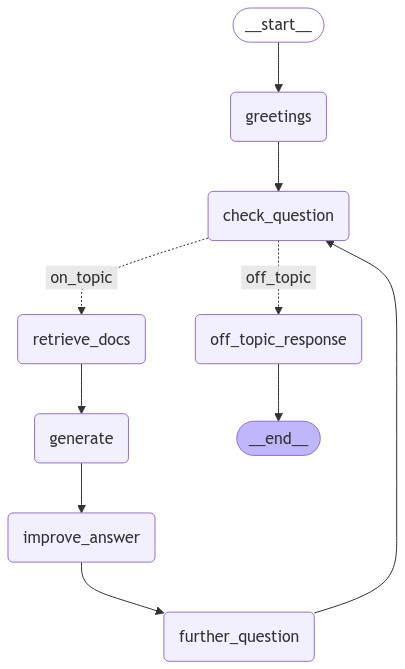

In [ ]:
# Display the workflow graph for visualization
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Invoke the application with the initial state
result = app.invoke({"start": True}, {"recursion_limit": 50})


Hello! Welcome to the restaurant. I will be your waiter. How can I help you?
what is your reco


I recommend trying the Siao Long Pao, especially the Traditional version with pork, paksoy, and shiitake mushroom; it's a classic dish that many guests really enjoy. For something lighter, the Vegetarian Soup is also a great choice; it's both flavorful and refreshing. If you're in the mood for something crunchy, the Gyoza, particularly the Shrimp Gyoza, is delicious. Would you like more details on any of these options or perhaps suggestions for a pairing?


suggestions for  pairing


For a delightful pairing, consider starting with the Vegetarian Soup, which is light and complements many dishes nicely. Following that, the Traditional Siao Long Pao pairs beautifully with a glass of Lello White wine, enhancing the flavors of the pork and shiitake. If you're leaning towards something crunchy, the Shrimp Gyoza goes well with a refreshing cold tea, like the Mint & Pineapple. Would you like to ex

In this notebook, we have built an agent that simulates a restaurant waiter, capable of interacting with customers in a friendly and professional manner. We utilized LangChain and LangGraph to construct the agent's workflow and integrated OpenAI's language models for generating responses.